# RNN simple pour séquences 1D (PyTorch)

**Objectifs pédagogiques :**
- Créer un petit jeu de données séquentiel synthétique.
- Construire un RNN simple avec PyTorch (`nn.RNN` + couche linéaire).
- Visualiser les **shapes** : `(batch_size, seq_len, d_in)` et la sortie du RNN.
- Montrer comment le réseau prédit la valeur suivante d'une séquence.

# Imports et device 

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# Génération d’un jeu de données séquentiel

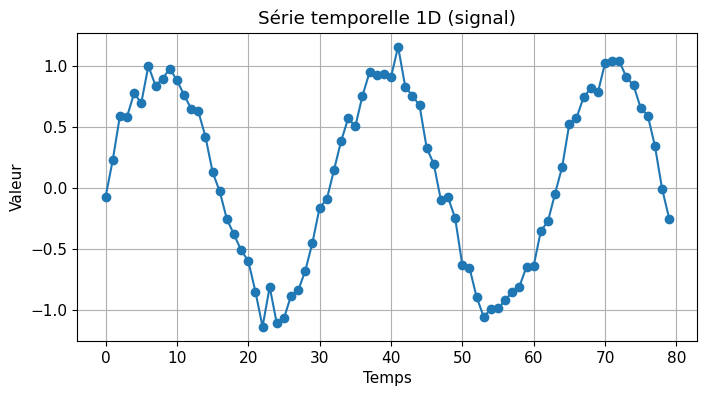

In [3]:
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["font.size"] = 11

T = 80  # longueur totale de la série
t = np.arange(T)
signal = np.sin(0.2 * t) + 0.1 * np.random.randn(T)

plt.plot(t, signal, marker="o")
plt.title("Série temporelle 1D (signal)")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()

# Construction des fenêtres pour le RNN
- X : séquences d'entrée (fenêtres)
- y : valeur suivante à prédire

In [5]:
def make_windows(sequence, window_size=5, horizon=1):
    """
    sequence : array 1D de longueur T
    window_size : nombre de pas dans l'entrée X
    horizon : combien de pas après la fenêtre on prédit (ici 1)
    """
    X = []
    y = []
    for start in range(0, len(sequence) - window_size - horizon + 1):
        end = start + window_size
        X.append(sequence[start:end])              # fenêtre d'entrée
        y.append(sequence[end + horizon - 1])      # cible à prédire
    return np.array(X), np.array(y)

window_size = 10
horizon = 1

X, y = make_windows(signal, window_size, horizon)
print("Shape X :", X.shape)  # (num_windows, window_size)
print("Shape y :", y.shape)  # (num_windows,)

Shape X : (70, 10)
Shape y : (70,)


# Visualisation des fenêtres et cibles

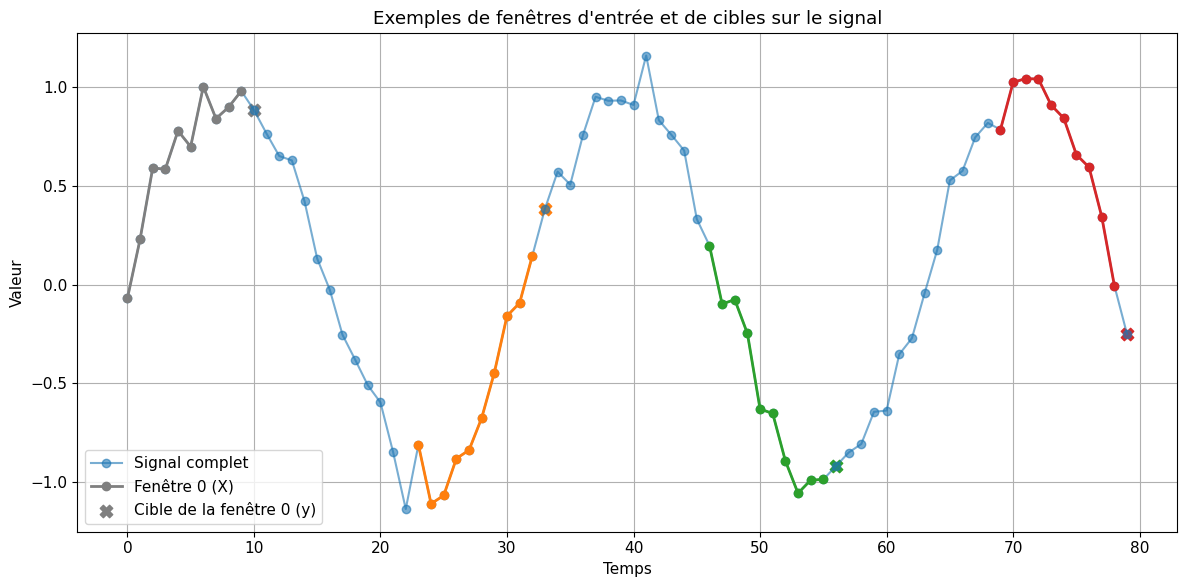

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(t, signal, marker="o", label="Signal complet", alpha=0.6)

# Nombre de fenêtres à illustrer
num_to_show = 4
indices = np.linspace(0, len(X) - 1, num_to_show, dtype=int)

colors = ["tab:grey", "tab:orange", "tab:green", "tab:red"]

for idx, color in zip(indices, colors):
    start = idx
    end = start + window_size
    target_index = end + horizon - 1
    
    # Fenêtre d'entrée
    ax.plot(
        t[start:end], signal[start:end],
        marker="o", linestyle="-", color=color,
        linewidth=2, label=f"Fenêtre {idx} (X)" if idx == indices[0] else None
    )
    
    # Cible associée
    ax.scatter(
        t[target_index], signal[target_index],
        color=color, marker="X", s=80,
        label=f"Cible de la fenêtre {idx} (y)" if idx == indices[0] else None
    )

ax.set_title("Exemples de fenêtres d'entrée et de cibles sur le signal")
ax.set_xlabel("Temps")
ax.set_ylabel("Valeur")
ax.grid(True)
ax.legend(loc="best")
plt.tight_layout()
plt.show()


# Passage en tenseurs PyTorch(shape 3D pour RNN)

RNN attend : (batch_size, seq_len, input_size)

In [15]:
X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)   # (N, seq_len, 1)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)   # (N, 1)
dataset = TensorDataset(X_t, y_t)

loader = DataLoader(dataset, batch_size=16, shuffle=True)

# RNN simple 

In [18]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h = self.rnn(x)
        return self.fc(out[:, -1, :])   # dernière sortie

model = SimpleRNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entraînement

Epoch 0 – Loss: 0.2366
Epoch 50 – Loss: 0.0112
Epoch 100 – Loss: 0.0045
Epoch 150 – Loss: 0.0057
Epoch 200 – Loss: 0.0055
Epoch 250 – Loss: 0.0107
Epoch 300 – Loss: 0.0145
Epoch 350 – Loss: 0.0030
Epoch 400 – Loss: 0.0009
Epoch 450 – Loss: 0.0005


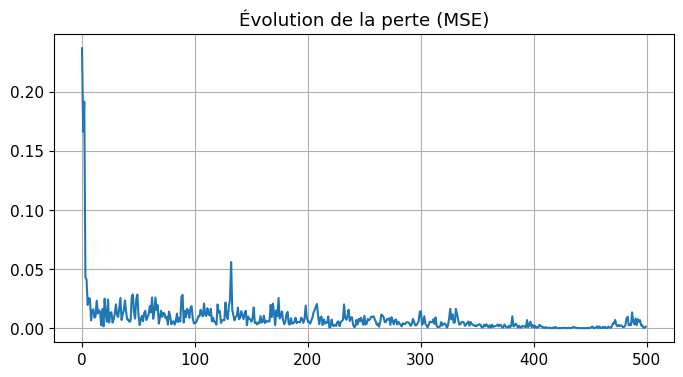

In [20]:
losses = []
epochs = 500

for ep in range(epochs):
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    if ep % 50 == 0:
        print(f"Epoch {ep} – Loss: {loss.item():.4f}")

plt.plot(losses)
plt.title("Évolution de la perte (MSE)")
plt.grid()
plt.show()

# Prédiction séquentielle

In [25]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()

# ----- Prédiction séquentielle complète -----

preds = []
input_seq = X_t[0].unsqueeze(0).to(device)   # première fenêtre (1, window, 1)

for _ in range(len(signal) - window_size):
    with torch.no_grad():
        next_val = model(input_seq)          # prédiction (1,1)

    preds.append(next_val.item())

    # Mise à jour de la fenêtre
    input_seq = torch.cat([input_seq[:, 1:, :], next_val.unsqueeze(0)], dim=1)

# Convertir la prédiction en array aligné temporellement
pred_t = np.array([np.nan]*window_size + preds)
real_t = signal[:len(pred_t)]


# Visualisation

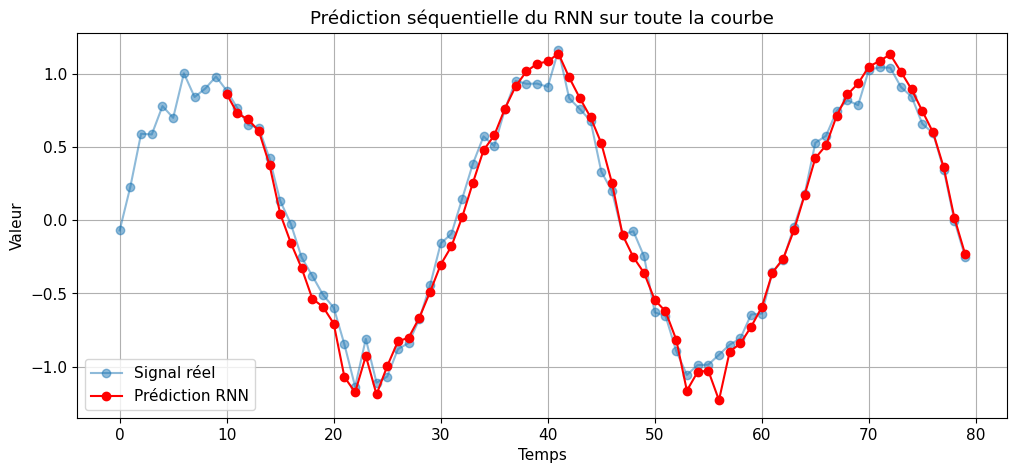

In [26]:
plt.figure(figsize=(12,5))

# vrai signal
plt.plot(t, signal, label="Signal réel", marker="o", alpha=0.5)

# prédiction
pred_t = np.arange(window_size, window_size + len(preds))
plt.plot(pred_t, preds, "-o", color="red", label="Prédiction RNN")

plt.title("Prédiction séquentielle du RNN sur toute la courbe")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.grid()
plt.legend()
plt.show()